In [1]:
from pyscf import gto,dft,scf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import jax.numpy as jnp
from ase import Atoms
from ase.io import read
import xcquinox as xce
import equinox as eqx
import os, optax, jax
import faulthandler
import pandas as pd
faulthandler.enable()
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
def split(el):
    import re
    #Splits a string on capital letter sequences, which should split a molecule into constituent atoms 
    # and amounts, then generates the correct number of constituent atoms if multiple
    res_list = [s for s in re.split("([A-Z][^A-Z]*)", el) if s]
    ret_list = []
    for res in res_list:
        if res[-1].isalpha():
            ret_list.append(res)
        else:
            nres = int(''.join([i for i in res if i.isnumeric()]))
            newres = ''.join([i for i in res if i.isalpha()])
            ret_list += nres*[newres]
    return ret_list

In [3]:
ref_trj = '/home/awills/Documents/Research/xcquinox/scripts/script_data/haunschild_g2/G297I.traj'
refs = read(ref_trj, ':')
for idx, at in enumerate(refs):
    print(idx, at, at.info)

ref_aes = {str(i.symbols): i.info['atomization_H'] for i in refs}
idx_ref_aes = {idx: i.info['atomization_H'] for idx, i in enumerate(refs)}

0 Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)) {'CO': True, 'energy': -113.20173021777055, 'atomization': 0.4142335363320095, 'atomization_ev': 11.271868661369064, 'atomization_H': 0.4142335363320095, 'openshell': False, 'name': 'Carbon monoxide', 'grid_level': 3}
1 Atoms(symbols='CS', pbc=False, calculator=SinglePointCalculator(...)) {'CS': True, 'energy': -435.87414183611736, 'atomization': 0.2740316507303354, 'atomization_ev': 7.456781030917735, 'atomization_H': 0.2740316507303354, 'openshell': False, 'name': 'Carbon monosulfide', 'grid_level': 3}
2 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'energy': -1.1723488681184566, 'atomization': 0.17434014967795244, 'atomization_ev': 4.7440371124327285, 'atomization_H': 0.17434014967795244, 'openshell': False, 'name': 'Dihydrogen', 'grid_level': 3}
3 Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...)) {'HF': True, 'energy': -100.36472229755955, 'atomization': 

# For Plotting Pure XC Functional Errors w.r.t. Literature Reference

In [71]:
td = '/home/awills/Documents/Research2/xcquinox_pt/val'
subds = ['pbe_xc', 'scan_xc', 'pbe0_xc']
#for full-dataset error measures
MSE_DCT = {subd: 0 for subd in subds}
RMSE_DCT = {subd: 0 for subd in subds}
#for system-by-system error measures
RSE_DCT = {subd: {} for subd in subds}
IDX_RSE_DCT = {subd: {} for subd in subds}

In [72]:
for subd in subds:
    cdir = os.path.join(td, subd)
    print(cdir)
    df = pd.read_csv(os.path.join(cdir, 'progress'), delimiter='\t')
    singles = [i for i in df['atoms.symbols'] if len(split(i)) == 1]
    atomic_ens = {single: float(df[df['atoms.symbols'] == single]['etot  (Har)'].values[0]) for single in singles}
    df['shiftidx'] = df['#idx'] - len(singles)
    df['AE'] = 0
    calc_aes = []
    ref_aes = []
    moldf = df[df['shiftidx'] >= 0]
    try:
        moldf.loc[:, 'REFAE'] = 0
    except:
        continue
    for idx, row in moldf.iterrows():
        try:
            en = float(row['etot  (Har)'])
            ress = split(row['atoms.symbols'])
            for res in ress:
                en -= atomic_ens[res]
            calc_aes.append(en)
            ref_aes.append(idx_ref_aes[row['shiftidx']])
            RSE_DCT[subd][row['atoms.symbols']] = np.sqrt((en - idx_ref_aes[row['shiftidx']])**2)
            IDX_RSE_DCT[subd][row['shiftidx']] = np.sqrt((en - idx_ref_aes[row['shiftidx']])**2)
        except Exception as e:
            print(e)
            calc_aes.append(np.nan)
            ref_aes.append(idx_ref_aes[row['shiftidx']])
            RSE_DCT[subd][row['atoms.symbols']] = np.nan
            IDX_RSE_DCT[subd][row['shiftidx']] = np.nan
    try:
        moldf.loc[:, 'AE'] = calc_aes
        moldf.loc[:, 'REFAE'] = ref_aes
        moldf.loc[:, 'SE'] = (moldf['AE'] - moldf['REFAE'])**2
        MSE = moldf['SE'].mean()
        RMSE = np.sqrt(MSE)
        MSE_DCT[subd] = MSE
        RMSE_DCT[subd] = RMSE
    except Exception as e:
        print(e)

/home/awills/Documents/Research2/xcquinox_pt/val/pbe_xc
/home/awills/Documents/Research2/xcquinox_pt/val/scan_xc
/home/awills/Documents/Research2/xcquinox_pt/val/pbe0_xc


/tmp/ipykernel_9791/4024690603.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moldf.loc[:, 'REFAE'] = 0
/tmp/ipykernel_9791/4024690603.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4300056452630088, -0.28648762661134697, -0.16648961328243989, -0.22691488940702992, -0.19463457066319734, -0.18306861322707846, -0.14047665301827134, -0.2245273598934432, -0.44165488710924033, -0.8071161235211548, -0.6695625233007949, -0.666415581068236, -0.4810966111004973, -0.19598274532866355, -0.08835850362761849, -0.37392271099317625, -0.2905614971406068, -0.10376257092320884, -0.5206224421600425, -0.47201244515545976, -0.17037790358144217, -0.4964688590045654, -0.392971358273

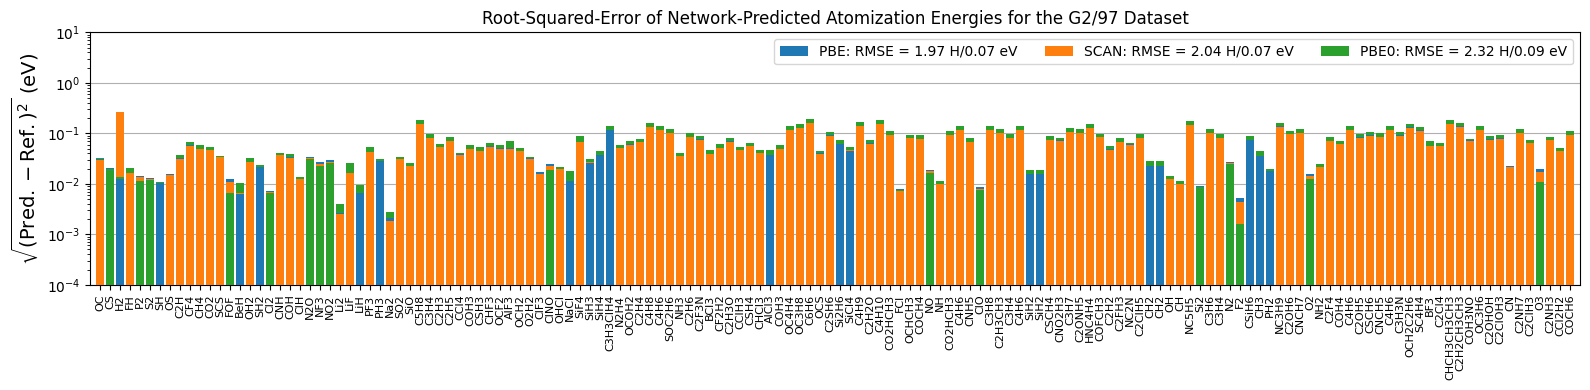

In [73]:
labs = [str(i.symbols) for i in refs]
xs = np.arange(0, len(labs))
CONV = 27.2114
# f = plt.figure(figsize=(16,12))
# axg = f.add_subplot(311)
# axm = f.add_subplot(312)
# axn = f.add_subplot(313)
# axs = [axg, axm, axn]
# axd = {'pbe_xc': axg, 'scan_xc': axm, 'pbe0_xc': axn}
f = plt.figure(figsize=(16,4))
axg = f.add_subplot(111)
axs = [axg]
axd = {'pbe_xc': axg, 'scan_xc': axg, 'pbe0_xc': axg}

for subd in subds:
    keys = sorted(list(RSE_DCT[subd].keys()))
    ax = axd[subd]
    ax.set_xticks(xs)
    ax.yaxis.grid()
    ax.set_yscale('log')
    ax.set_xlim(-1, xs[-1]+1)
    ax.set_ylim(1e-4, 1e1)
    ax.set_ylabel('$\sqrt{(\mathrm{Pred.}-\mathrm{Ref.})^2}$ (eV)', fontsize=14)
    ax.set_xticklabels(labs, rotation=90, fontsize=8)
    if len(axs) == 3:
        if subd == 'pbe_xc':
            ax.set_title('Root-Squared-Error of Network-Predicted Atomization Energies for the G2/97 Dataset\n{}'.format(subd.split('_')[0].upper()))
        else:
            ax.set_title('{}'.format(subd.split('_')[0].upper()))
    else:
        ax.set_title('Root-Squared-Error of Network-Predicted Atomization Energies for the G2/97 Dataset')

    dct = RSE_DCT[subd]
    vals = []
    for lab in labs:
        try:
            vals.append(dct[lab]/CONV)
        except Exception as e:
            print(e)
            vals.append(np.nan)
    try:
        thislab = '{}: RMSE = {:3.2f} H/{:3.2f} eV'.format(subd.split('_')[0].upper(),
                                                 RMSE_DCT[subd],
                                                 RMSE_DCT[subd]/CONV)
        ax.bar(xs, vals, label=thislab)
    except Exception as e:
        print(e)
        continue
    #make higher errors further back
    for bars in zip(*ax.containers):
        order = np.argsort(np.argsort([b.get_height() for b in bars]))
        for bar, bar_order in zip(bars, order):
            bar.set_zorder(2 + len(ax.containers) - bar_order)
    ax.legend(ncol=4)
    plt.tight_layout()

# For Plotting Network Errors w.r.t. Literature Reference

In [84]:
td = '/home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf'
subds = ['ran', 'pt/pbe', 'pt/scan', 'pt/pbe0']
# subds = ['ran', 'pt/pbe', 'pt/pbe0']
MSE_DCT = {'ran': {},
           'pt/pbe': {},
          'pt/pbe0': {},
          'pt/scan': {}}
RMSE_DCT = {'ran': {},
           'pt/pbe': {},
          'pt/pbe0': {},
          'pt/scan': {}}
RSE_DCT = {'ran': {},
           'pt/pbe': {},
          'pt/pbe0': {},
          'pt/scan': {}}
IDX_RSE_DCT = {'ran': {},
           'pt/pbe': {},
          'pt/pbe0': {},
          'pt/scan': {}}


In [85]:
for subd in subds:
    cdir = os.path.join(td, subd)
    print(cdir)
    calcds = sorted([i for i in os.listdir(cdir) if os.path.isdir(os.path.join(cdir, i))])
    print(calcds)
    print(f'Reading in progress dataframes in {cdir} and {calcds}')
    #includes nonlocal
    prog_dfs = {net: pd.read_csv(os.path.join(cdir, net, 'progress'), delimiter='\t') for net in calcds if 'progress' in os.listdir(os.path.join(cdir, net))}
    #does not
    # prog_dfs = {net: pd.read_csv(os.path.join(cdir, net, 'progress'), delimiter='\t') for net in calcds if 'nl' not in net}
    for idx, net in enumerate(calcds):
        # if 'nl' in net:
        #     continue
        RSE_DCT[subd][net] = {}
        IDX_RSE_DCT[subd][net] = {}
        df = prog_dfs.get(net, None)
        if type(df) == type(None):
            continue
        singles = [i for i in df['atoms.symbols'] if len(split(i)) == 1]
        atomic_ens = {single: float(df[df['atoms.symbols'] == single]['etot  (Har)'].values[0]) for single in singles}
        df['shiftidx'] = df['#idx'] - len(singles)
        df['AE'] = 0
        calc_aes = []
        ref_aes = []
        moldf = df[df['shiftidx'] >= 0]
        try:
            moldf.loc[:, 'REFAE'] = 0
        except:
            continue
        for idx, row in moldf.iterrows():
            try:
                en = float(row['etot  (Har)'])
                ress = split(row['atoms.symbols'])
                for res in ress:
                    en -= atomic_ens[res]
                calc_aes.append(en)
                ref_aes.append(idx_ref_aes[row['shiftidx']])
                RSE_DCT[subd][net][row['atoms.symbols']] = np.sqrt((en - idx_ref_aes[row['shiftidx']])**2)
                IDX_RSE_DCT[subd][net][row['shiftidx']] = np.sqrt((en - idx_ref_aes[row['shiftidx']])**2)
            except Exception as e:
                print(e)
                calc_aes.append(np.nan)
                ref_aes.append(idx_ref_aes[row['shiftidx']])
                RSE_DCT[subd][net][row['atoms.symbols']] = np.nan
                IDX_RSE_DCT[subd][net][row['shiftidx']] = np.nan
        try:
            moldf.loc[:, 'AE'] = calc_aes
            moldf.loc[:, 'REFAE'] = ref_aes
            moldf.loc[:, 'SE'] = (moldf['AE'] - moldf['REFAE'])**2
            MSE = moldf['SE'].mean()
            RMSE = np.sqrt(MSE)
            MSE_DCT[subd][net] = MSE
            RMSE_DCT[subd][net] = RMSE
        except Exception as e:
            print(e)

/home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf/ran
['xc_3_16_c0_gga', 'xc_3_16_c0_mgga', 'xc_3_16_c0_nl', 'xc_3_16_c1_gga', 'xc_3_16_c1_mgga', 'xc_3_16_c1_nl', 'xc_3_16_nc0_gga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_gga', 'xc_3_16_nc1_mgga', 'xc_3_16_nc1_nl']
Reading in progress dataframes in /home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf/ran and ['xc_3_16_c0_gga', 'xc_3_16_c0_mgga', 'xc_3_16_c0_nl', 'xc_3_16_c1_gga', 'xc_3_16_c1_mgga', 'xc_3_16_c1_nl', 'xc_3_16_nc0_gga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_gga', 'xc_3_16_nc1_mgga', 'xc_3_16_nc1_nl']
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string

/tmp/ipykernel_9791/1996857708.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moldf.loc[:, 'REFAE'] = 0
/tmp/ipykernel_9791/1996857708.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.7587608093291323, -0.5477045627087023, -0.077668842389511, -0.2890581415466077, -0.4960927802077322, -0.46186583967744355, -0.1999899440127596, -0.5755908848940408, -0.8018766750415726, -1.8827253897930802, -0.7769549337494138, -1.4183720308695342, -1.0723169849150622, -0.6695050082210372, -0.08897144068596463, -0.5346164375755855, -0.40674673710859754, -0.3196781731246574, -0.9051340761476357, -0.8654599488463678, -0.23570055359566633, -1.4721200919289146, -1.1495116418054465, -1.

'O'
'C'
'H'
'F'
'P'
'S'
'S'
'O'
'C'
'C'
'C'
'C'
'S'
'F'
'Be'
'O'
'S'
'Cl'
'C'
'C'
'Cl'
'N'
'N'
'N'
'Li'
'Li'
'Li'
'P'
'P'
'Na'
'S'
'Si'
'C'
'C'
'C'
'C'
'C'
'C'
'C'
'C'
'O'
'Al'
'O'
'O'
'Cl'
'Cl'
'O'
'Na'
'Si'
'Si'
'Si'
'C'
'N'
'O'
'C'
'C'
'C'
'S'
'N'
'C'
'C'
'B'
'C'
'C'
'C'
'C'
'C'
'Al'
'C'
'O'
'O'
'O'
'C'
'H'
'F'
'P'
'S'
'S'
'O'
'C'
'C'
'C'
'C'
'S'
'F'
'Be'
'O'
'S'
'Cl'
'C'
'C'
'Cl'
'N'
'N'
'N'
'Li'
'Li'
'Li'
'P'
'P'
'Na'
'S'
'Si'
'C'
'C'
'C'
'C'
'C'
'C'
'C'
'C'
'O'
'Al'
'O'
'O'
'Cl'
'Cl'
'O'
'Na'
'Si'
'Si'
'Si'
'C'
'N'
'O'
'C'
'C'
'C'
'S'
'N'
'C'
'C'
'B'
'C'
'C'
'C'
'C'
'C'
'Al'
'C'
'O'
'O'
'O'
'C'
'H'
'F'
'P'
'S'
'S'
'O'
'C'
'C'
'C'
'C'
'S'
'F'
'Be'
'O'
'S'
'Cl'
'C'
'C'
'Cl'
'N'
'N'
'N'
'Li'
'Li'
'Li'
'P'
'P'
'Na'
'S'
'Si'
'C'
'C'
'C'
'C'
'C'
'C'
'C'
'C'
'O'
'Al'
'O'
'O'
'Cl'
'Cl'
'O'
'Na'
'Si'
'Si'
'Si'
'C'
'N'
'O'
'C'
'C'
'C'
'S'
'N'
'C'
'C'
'B'
'C'
'C'
'C'
'C'
'C'
'Al'
'C'
'O'
'O'
'O'
'C'
'H'
'F'
'P'
'S'
'S'
'O'
'C'
'C'
'C'
'C'
'S'
'F'
'Be'
'O'
'S'
'Cl'
'C'
'C'
'Cl'
'N'
'N'
'N'
'

/tmp/ipykernel_9791/1996857708.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moldf.loc[:, 'REFAE'] = 0
/tmp/ipykernel_9791/1996857708.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.6721964412309163, -0.49054139610717584, -0.05512395539114934, -0.246038342541608, -0.44844931124555387, -0.41513144942132385, -0.17120603323425426, -0.5092603984469974, -0.7034450554919669, -1.6449832908537587, -0.6531876925382605, -1.2546389916093688, -0.9598377583899378, -0.5687798262661801, -0.06919505966825673, -0.4505799731174385, -0.34862283749083295, -0.28009700642292046, -0.7939349879980195, -0.756890339683066, -0.20298967505149618, -1.302434389027539, -0.9868545378665203, 

['xc_3_16_c0_gga', 'xc_3_16_c1_gga', 'xc_3_16_nc0_gga', 'xc_3_16_nc1_gga']
['xc_3_16_c0_mgga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_mgga']
['xc_3_16_c0_nl', 'xc_3_16_c1_nl', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_nl']
['xc_3_16_c0_gga', 'xc_3_16_c1_gga', 'xc_3_16_nc0_gga', 'xc_3_16_nc1_gga']
['xc_3_16_c0_mgga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_mgga']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['xc_3_16_c0_nl', 'xc_3_16_c1_nl', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_nl']
['xc_3_16_c0_gga', 'xc_3_16_c1_gga', 'xc_3_16_nc0_gga', 'xc_3_16_nc1_gga']
['xc_3_16_c0_mgga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_mgga']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['xc_3_16_c0_nl', 'xc_3_16_c1_nl', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_nl']
['xc_3_16_c0_gga', 'xc_3_16_c1_gga', 'xc_3_16_nc0_gga', 'xc_3_16_nc1_gga']
['xc_3_16_c0_mgga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_mgga']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['xc_3_16_c0_nl', 'xc_3_16_c1_nl', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_nl']


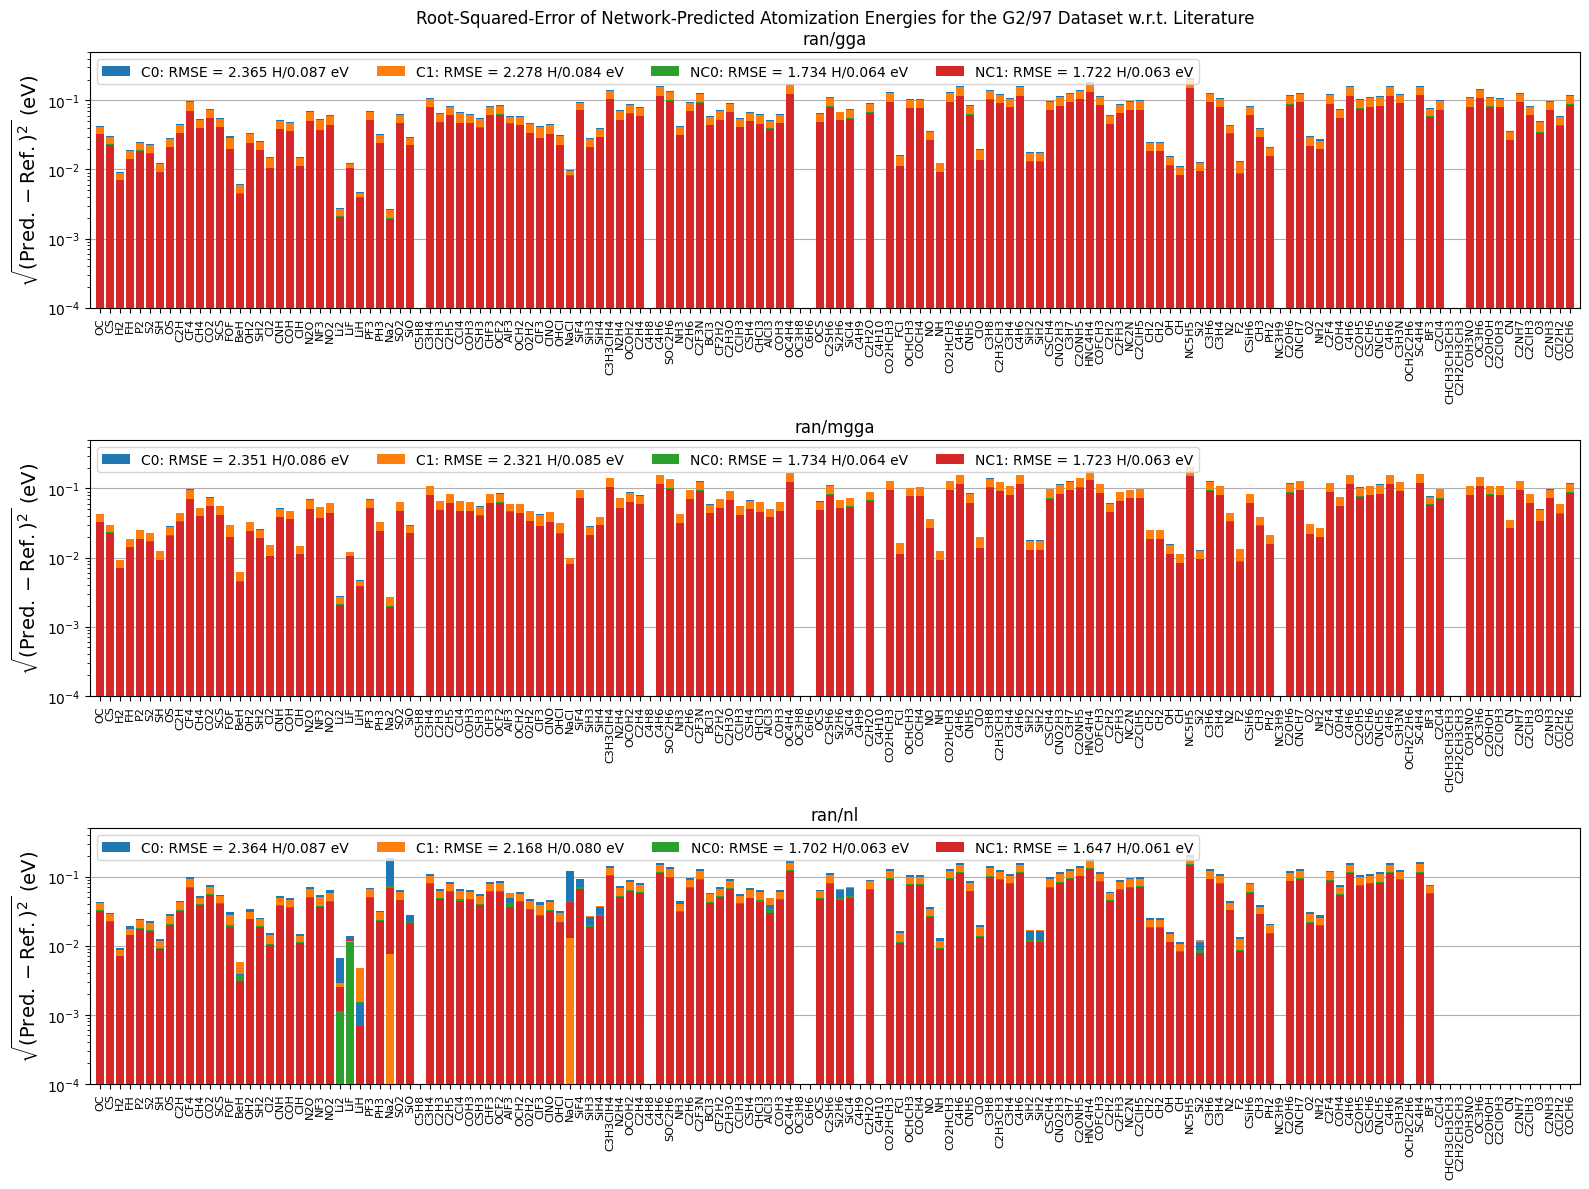

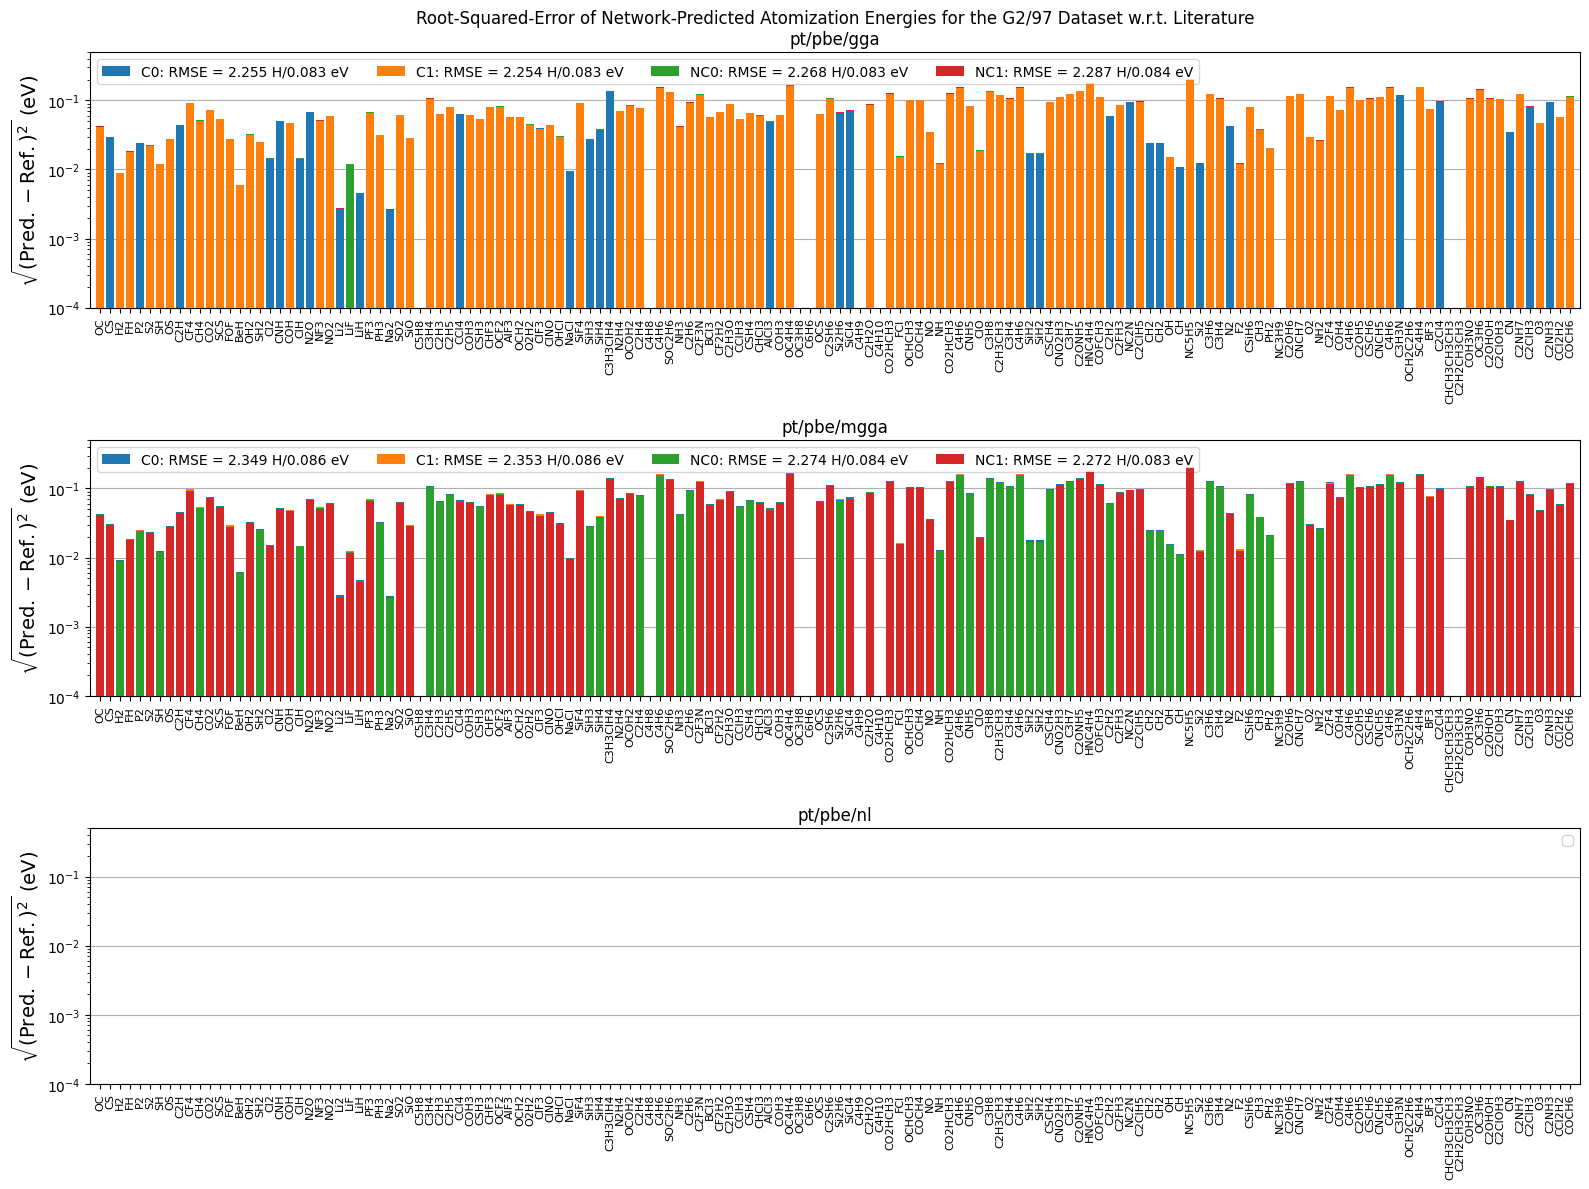

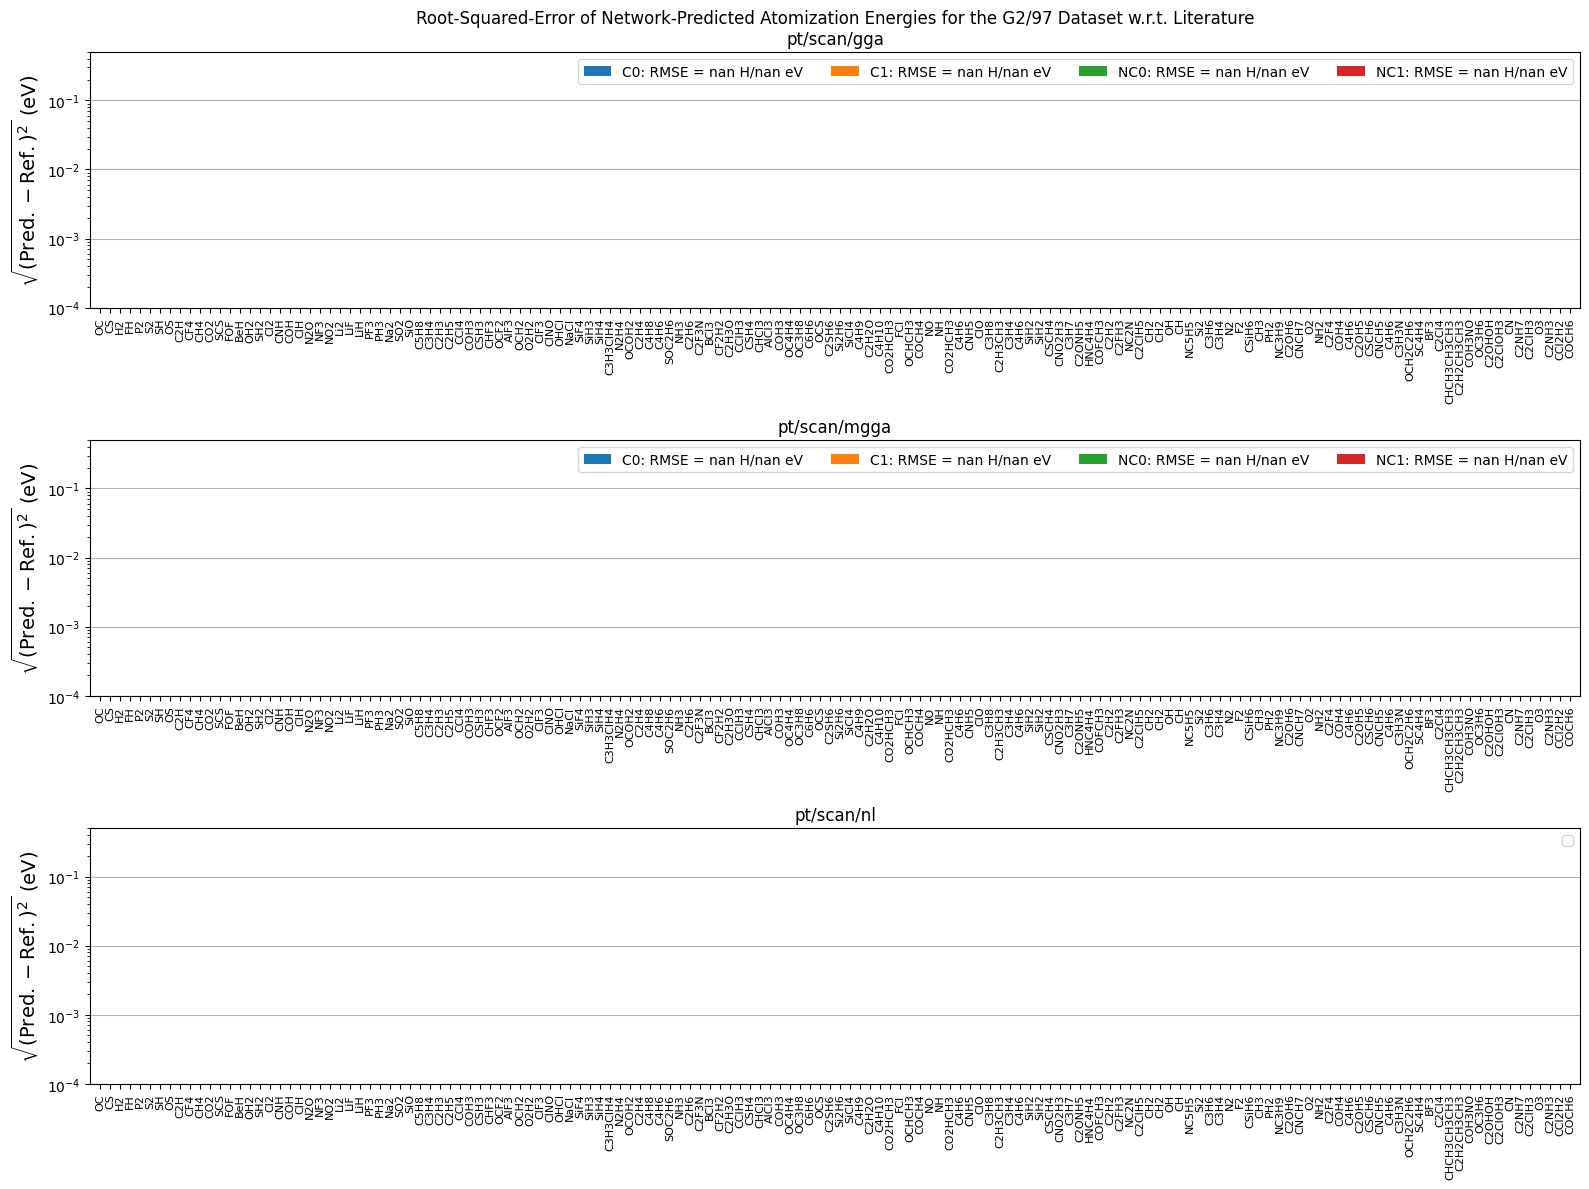

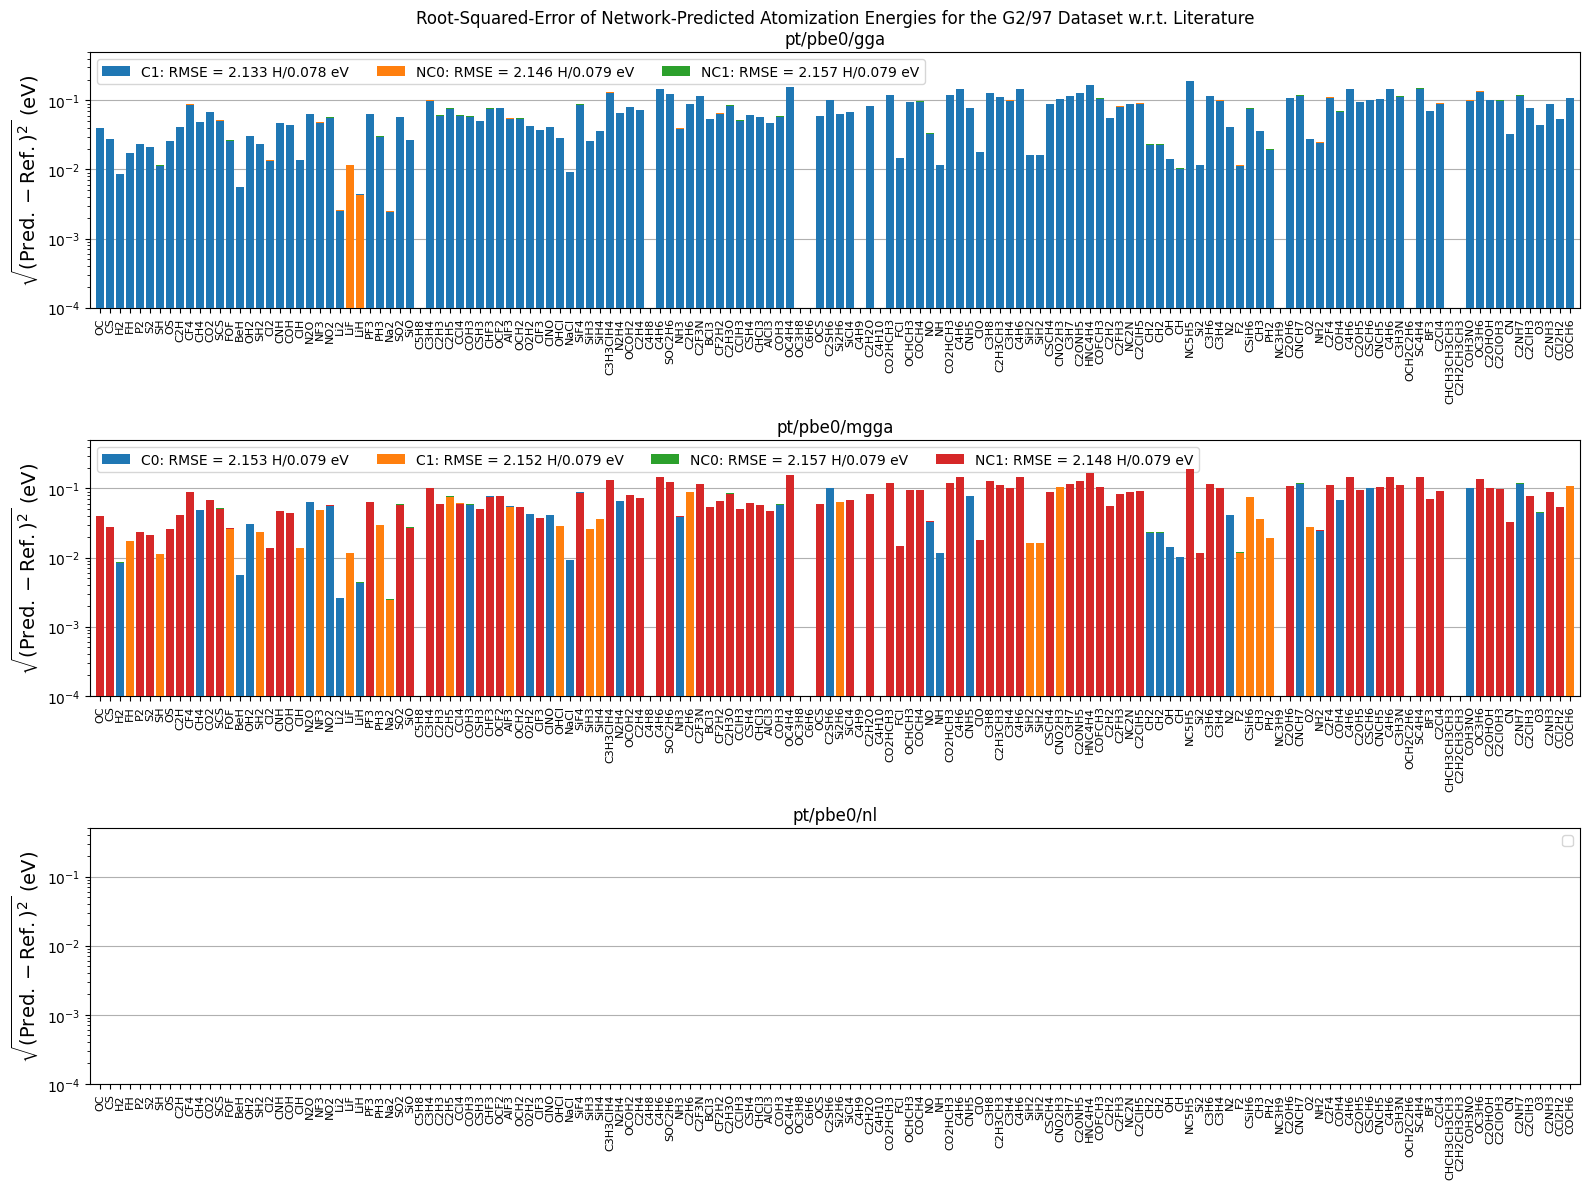

In [86]:
labs = [str(i.symbols) for i in refs]
xs = np.arange(0, len(labs))
CONV = 27.2114
for subd in subds:
    keys = sorted(list(RSE_DCT[subd].keys()))
    lds = [ [i for i in keys if '_gga' in i], [i for i in keys if '_mgga' in i], [i for i in keys if '_nl' in i] ]
    f = plt.figure(figsize=(16,12))
    axg = f.add_subplot(311)
    axm = f.add_subplot(312)
    axn = f.add_subplot(313)
    axd = {'GGA': axg, 'MGGA': axm, 'NL': axn}
    for idx, levelnet in enumerate(lds):
        print(levelnet)
        if not len(levelnet):
            continue
        level = levelnet[0].split('_')[-1].upper()
        ax = axd[level]
        ax.set_xticks(xs)
        ax.yaxis.grid()
        ax.set_yscale('log')
        ax.set_xlim(-1, xs[-1]+1)
        ax.set_ylim(1e-4, 5e-1)
        ax.set_ylabel('$\sqrt{(\mathrm{Pred.}-\mathrm{Ref.})^2}$ (eV)', fontsize=14)
        ax.set_xticklabels(labs, rotation=90, fontsize=8)
        if level == 'GGA':
            ax.set_title('Root-Squared-Error of Network-Predicted Atomization Energies for the G2/97 Dataset w.r.t. Literature\n{}/{}'.format(subd, levelnet[0].split('_')[-1]))
        else:
            ax.set_title('{}/{}'.format(subd, levelnet[0].split('_')[-1]))
        for net in levelnet:
            dct = RSE_DCT[subd][net]
            vals = []
            for lab in labs:
                try:
                    vals.append(dct[lab]/CONV)
                except Exception as e:
                    # print(e)
                    vals.append(np.nan)
            try:
                thislab = '{}: RMSE = {:3.3f} H/{:3.3f} eV'.format(net.split('_')[-2].upper(),
                                                         RMSE_DCT[subd][net],
                                                         RMSE_DCT[subd][net]/CONV)
                ax.bar(xs, vals, label=thislab)
            except:
                continue
        #make higher errors further back
        for bars in zip(*ax.containers):
            order = np.argsort(np.argsort([b.get_height() for b in bars]))
            for bar, bar_order in zip(bars, order):
                bar.set_zorder(2 + len(ax.containers) - bar_order)
        ax.legend(ncol=4)
        plt.tight_layout()

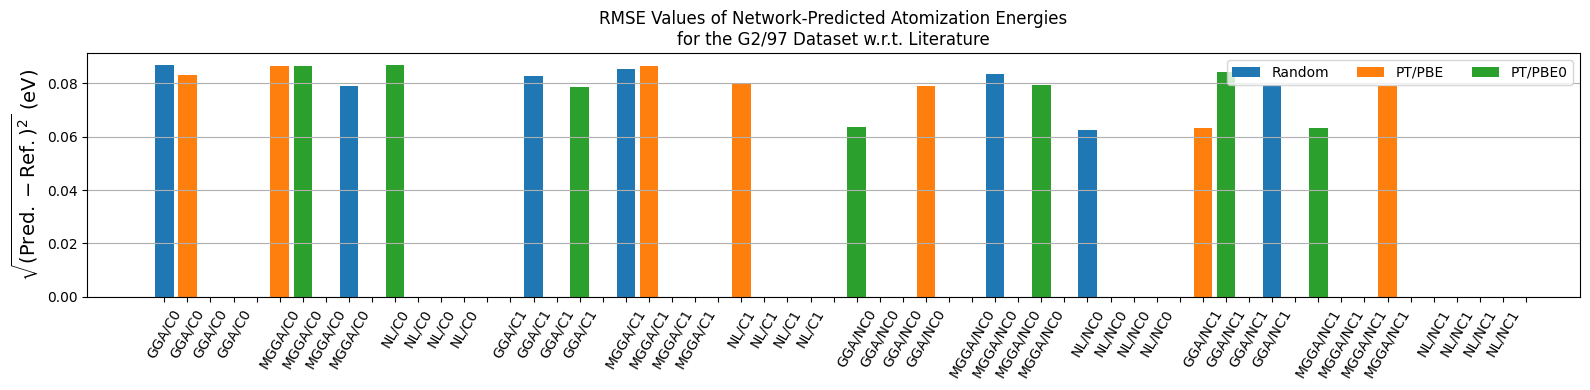

In [77]:
f = plt.figure(figsize=(16,4))
ax = f.add_subplot(111)
# ax.set_yscale('log')
ax.yaxis.grid()
ax.set_title('RMSE Values of Network-Predicted Atomization Energies\nfor the G2/97 Dataset w.r.t. Literature')
ax.set_ylabel('$\sqrt{(\mathrm{Pred.}-\mathrm{Ref.})^2}$ (eV)', fontsize=14)
#want to group by ran+pt/pbe0+pt/scan for a given network
nets = sorted(list(RMSE_DCT['ran'].keys()))
allgroups = []
alllabs = []
for net in nets:
    thisgroup = []
    thislabs = []
    for subd in subds:
        try:
            thisgroup.append(RMSE_DCT[subd][net]/CONV)
        except:
            thisgroup.append(0)
        thislabs.append(net.split('_')[-1].upper()+'/'+net.split('_')[-2].upper())
    thisgroup.append(0)
    thislabs.append('')

    allgroups += thisgroup
    alllabs += thislabs
xs = np.arange(0, len(allgroups))
ax.bar(xs[::4], allgroups[::4], label='Random')
ax.bar(xs[1::4], allgroups[1::4], label='PT/PBE')
ax.bar(xs[2::4], allgroups[2::4], label='PT/PBE0')
ax.set_xticks(xs)
ax.set_xticklabels(alllabs, rotation=60)
ax.legend(ncol=3)
plt.tight_layout()

# For Plotting Network Errors w.r.t. Corresponding Functional Reference

In [87]:
rd = '/home/awills/Documents/Research2/xcquinox_pt/val'
refxcs = ['pbe_xc', 'scan_xc', 'pbe0_xc']
ref_dfs = {ref: pd.read_csv(os.path.join(rd, ref, 'progress'), delimiter='\t') for ref in refxcs}

Below, we compare total energy predictions between the networks pre-trained to fit a functional and the functional's predictions.

In [88]:
td = '/home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf'
# subds = ['pt/pbe', 'pt/scan', 'pt/pbe0']
subds = ['pt/pbe', 'pt/scan', 'pt/pbe0']
MSE_DCT = {subd: {} for subd in subds}
RMSE_DCT = {subd: {} for subd in subds}
RSE_DCT = {subd: {} for subd in subds}
IDX_RSE_DCT = {subd: {} for subd in subds}
ref_lookup = {'pt/pbe':'pbe_xc', 'pt/scan':'scan_xc', 'pt/pbe0':'pbe0_xc'}

In [89]:
for subd in subds:
    cdir = os.path.join(td, subd)
    print(cdir)
    calcds = sorted([i for i in os.listdir(cdir) if os.path.isdir(os.path.join(cdir, i))])
    print(calcds)
    print(f'Reading in progress dataframes in {cdir} and {calcds}')
    # prog_dfs = {net: pd.read_csv(os.path.join(cdir, net, 'progress'), delimiter='\t') for net in calcds}
    prog_dfs = {net: pd.read_csv(os.path.join(cdir, net, 'progress'), delimiter='\t') for net in calcds if 'progress' in os.listdir(os.path.join(cdir, net))}
    refdf = ref_dfs[ref_lookup[subd]]
    syms = refdf['atoms.symbols'].values
    for idx, net in enumerate(calcds):
        # if 'nl' in net:
        #     continue
        RSE_DCT[subd][net] = {}
        IDX_RSE_DCT[subd][net] = {}
        try:
            df = prog_dfs[net]
        except:
            continue
        #df has SKIPPED values in it, so cast to numeric and force those into np.nans
        rse_energy_errors = np.sqrt( (refdf['etot  (Har)'] - pd.to_numeric(df['etot  (Har)'], errors='coerce') )**2)
        mse = np.mean( (refdf['etot  (Har)'] - pd.to_numeric(df['etot  (Har)'], errors='coerce') )**2 )
        rmse = np.sqrt(mse)
        RSE_DCT[subd][net] = {sym: rse_energy_errors[sidx] for sidx, sym in enumerate(syms)}
        MSE_DCT[subd][net] = mse
        RMSE_DCT[subd][net] = rmse

/home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf/pt/pbe
['xc_3_16_c0_gga', 'xc_3_16_c0_mgga', 'xc_3_16_c0_nl', 'xc_3_16_c1_gga', 'xc_3_16_c1_mgga', 'xc_3_16_c1_nl', 'xc_3_16_nc0_gga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_gga', 'xc_3_16_nc1_mgga', 'xc_3_16_nc1_nl']
Reading in progress dataframes in /home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf/pt/pbe and ['xc_3_16_c0_gga', 'xc_3_16_c0_mgga', 'xc_3_16_c0_nl', 'xc_3_16_c1_gga', 'xc_3_16_c1_mgga', 'xc_3_16_c1_nl', 'xc_3_16_nc0_gga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_gga', 'xc_3_16_nc1_mgga', 'xc_3_16_nc1_nl']
/home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf/pt/scan
['xc_3_16_c0_gga', 'xc_3_16_c0_mgga', 'xc_3_16_c0_nl', 'xc_3_16_c1_gga', 'xc_3_16_c1_mgga', 'xc_3_16_c1_nl', 'xc_3_16_nc0_gga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_gga', 'xc_3_16_nc1_mgga', 'xc_3_16_nc1_nl']
Reading in progress dataframes in /home/awills/Documents/Research2/xcquinox_pt/val/ct

pt/pbe ['xc_3_16_c0_gga', 'xc_3_16_c1_gga', 'xc_3_16_nc0_gga', 'xc_3_16_nc1_gga']
pt/pbe xc_3_16_c0_gga
pt/pbe xc_3_16_c1_gga
pt/pbe xc_3_16_nc0_gga
pt/pbe xc_3_16_nc1_gga
pt/pbe ['xc_3_16_c0_mgga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_mgga']
pt/pbe xc_3_16_c0_mgga
pt/pbe xc_3_16_c1_mgga
pt/pbe xc_3_16_nc0_mgga
pt/pbe xc_3_16_nc1_mgga


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pt/pbe ['xc_3_16_c0_nl', 'xc_3_16_c1_nl', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_nl']
pt/pbe xc_3_16_c0_nl
pt/pbe xc_3_16_c1_nl
pt/pbe xc_3_16_nc0_nl
pt/pbe xc_3_16_nc1_nl
pt/scan ['xc_3_16_c0_gga', 'xc_3_16_c1_gga', 'xc_3_16_nc0_gga', 'xc_3_16_nc1_gga']
pt/scan xc_3_16_c0_gga
pt/scan xc_3_16_c1_gga
pt/scan xc_3_16_nc0_gga
pt/scan xc_3_16_nc1_gga
pt/scan ['xc_3_16_c0_mgga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_mgga']
pt/scan xc_3_16_c0_mgga
pt/scan xc_3_16_c1_mgga
pt/scan xc_3_16_nc0_mgga
pt/scan xc_3_16_nc1_mgga


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pt/scan ['xc_3_16_c0_nl', 'xc_3_16_c1_nl', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_nl']
pt/scan xc_3_16_c0_nl
pt/scan xc_3_16_c1_nl
pt/scan xc_3_16_nc0_nl
pt/scan xc_3_16_nc1_nl
pt/pbe0 ['xc_3_16_c0_gga', 'xc_3_16_c1_gga', 'xc_3_16_nc0_gga', 'xc_3_16_nc1_gga']
pt/pbe0 xc_3_16_c0_gga
pt/pbe0 xc_3_16_c1_gga
pt/pbe0 xc_3_16_nc0_gga
pt/pbe0 xc_3_16_nc1_gga
pt/pbe0 ['xc_3_16_c0_mgga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_mgga']
pt/pbe0 xc_3_16_c0_mgga
pt/pbe0 xc_3_16_c1_mgga
pt/pbe0 xc_3_16_nc0_mgga
pt/pbe0 xc_3_16_nc1_mgga


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pt/pbe0 ['xc_3_16_c0_nl', 'xc_3_16_c1_nl', 'xc_3_16_nc0_nl', 'xc_3_16_nc1_nl']
pt/pbe0 xc_3_16_c0_nl
pt/pbe0 xc_3_16_c1_nl
pt/pbe0 xc_3_16_nc0_nl
pt/pbe0 xc_3_16_nc1_nl


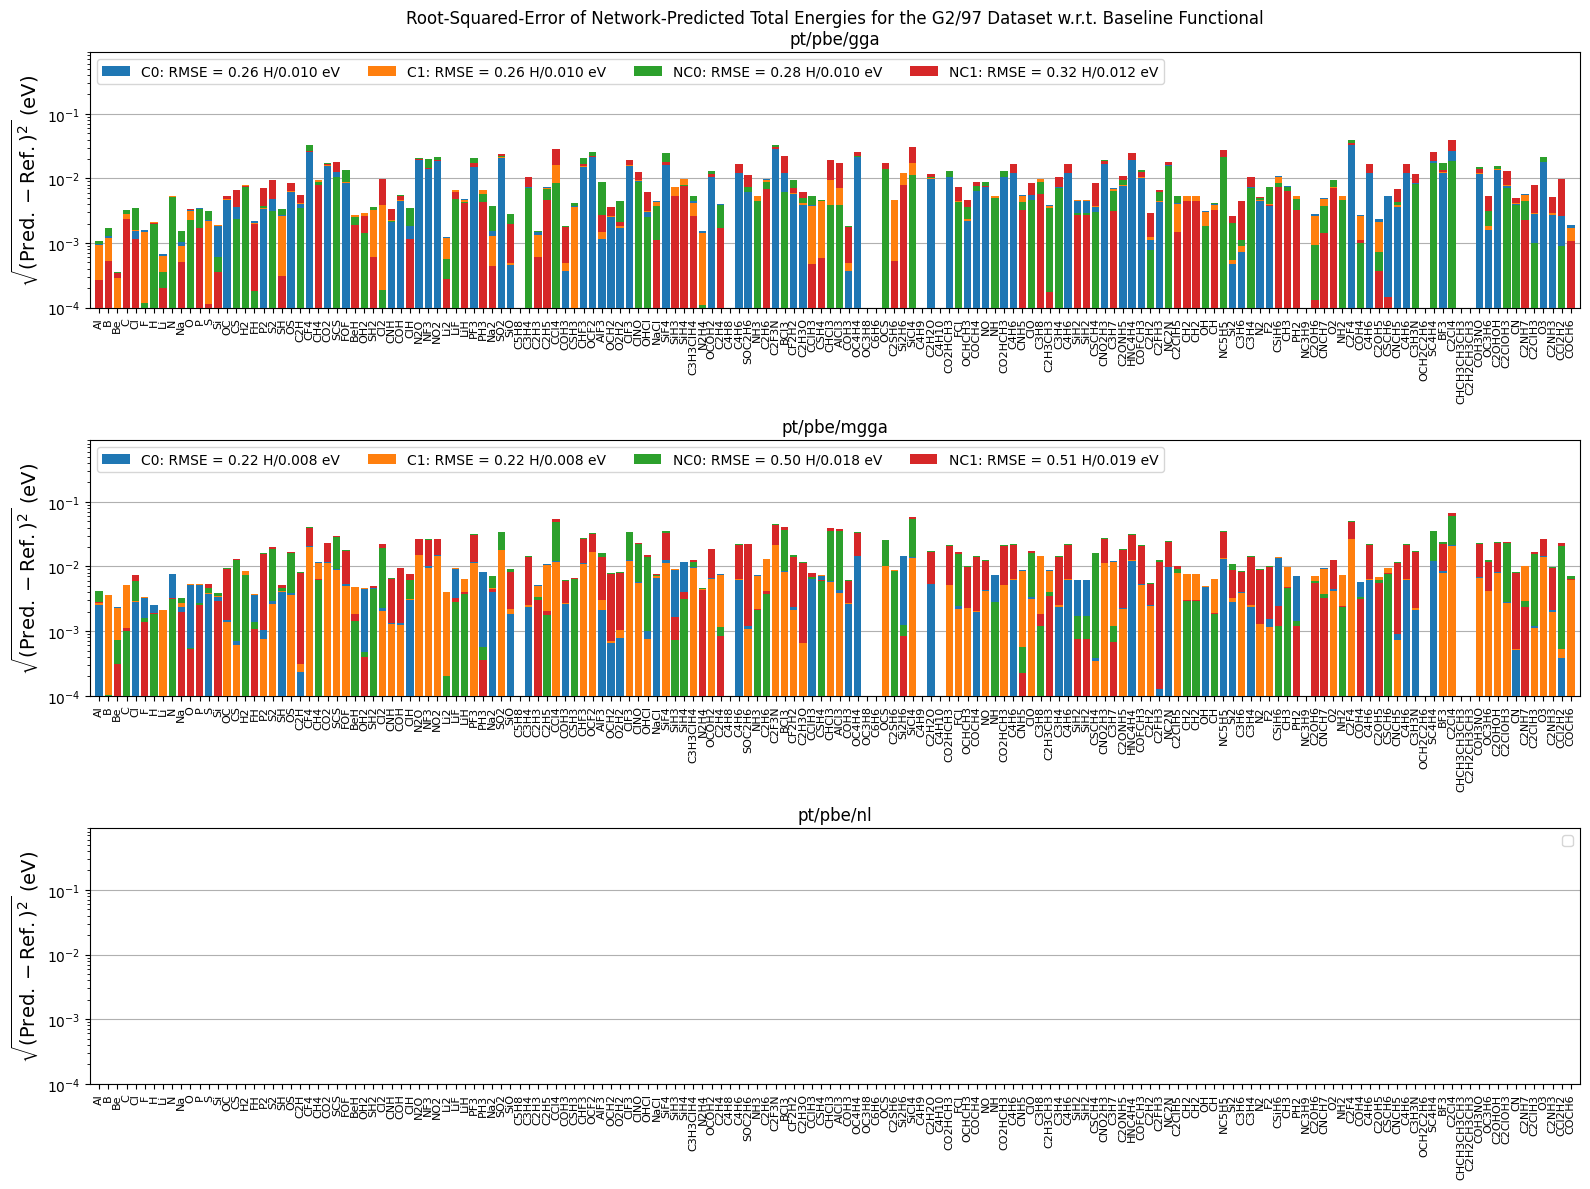

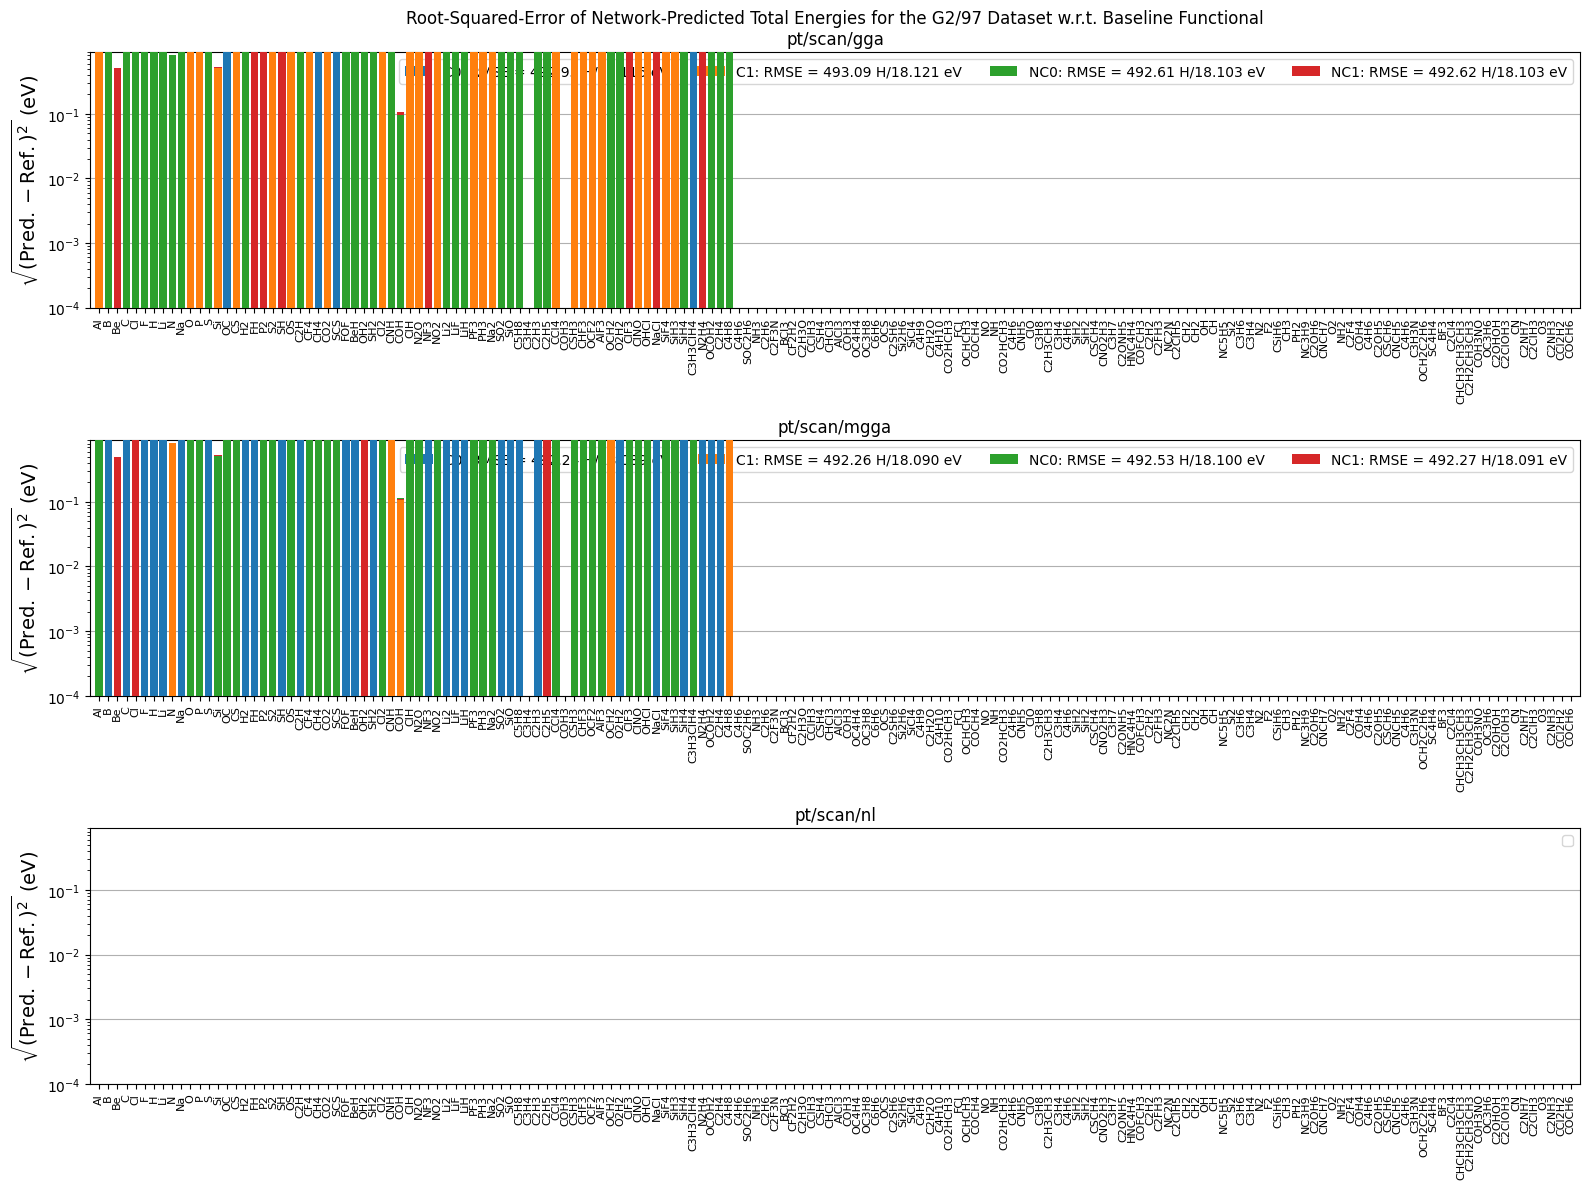

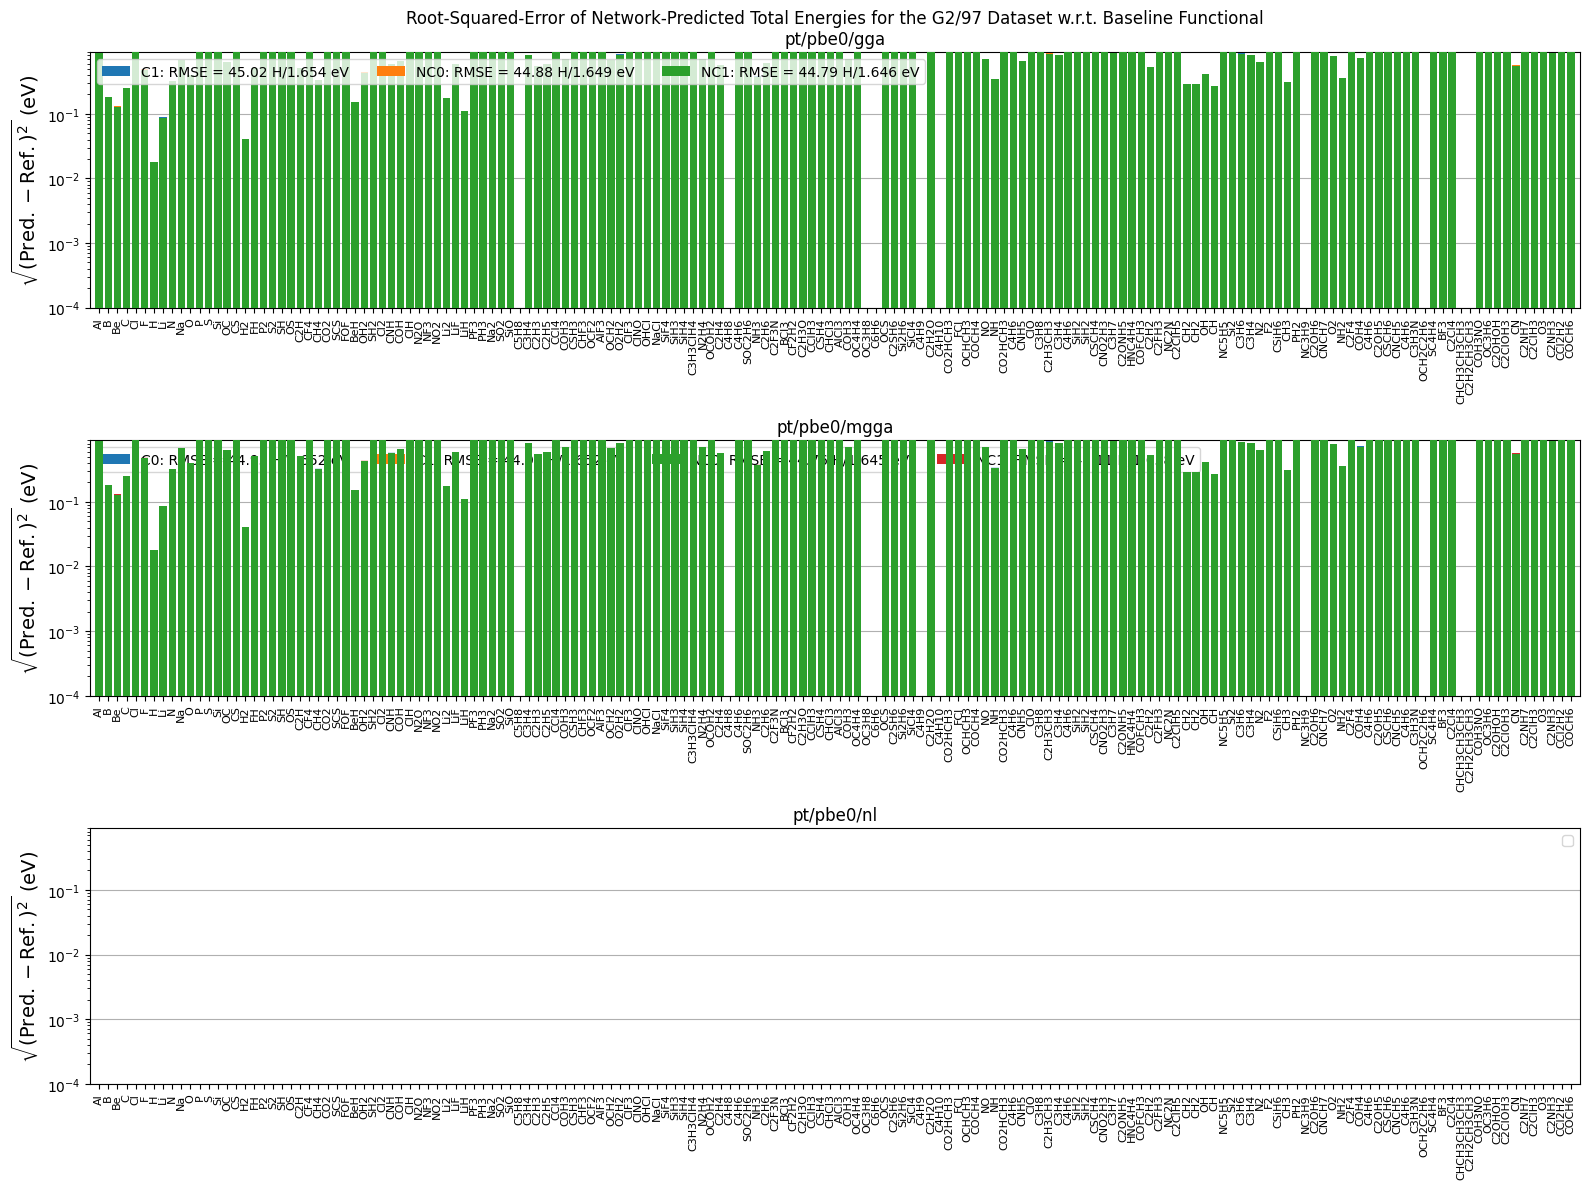

In [90]:
labs = ref_dfs['pbe_xc']['atoms.symbols'].values
xs = np.arange(0, len(labs))
CONV = 27.2114
for subd in subds:
    keys = sorted(list(RSE_DCT[subd].keys()))
    lds = [ [i for i in keys if '_gga' in i], [i for i in keys if '_mgga' in i], [i for i in keys if '_nl' in i] ]
    f = plt.figure(figsize=(16,12))
    axg = f.add_subplot(311)
    axm = f.add_subplot(312)
    axn = f.add_subplot(313)
    axd = {'GGA': axg, 'MGGA': axm, 'NL': axn}
    for idx, levelnet in enumerate(lds):
        if not len(levelnet):
            continue
        print(subd, levelnet)
        level = levelnet[0].split('_')[-1].upper()
        ax = axd[level]
        ax.set_xticks(xs)
        ax.yaxis.grid()
        ax.set_yscale('log')
        ax.set_xlim(-1, xs[-1]+1)
        ax.set_ylim(1e-4, 9e-1)
        ax.set_ylabel('$\sqrt{(\mathrm{Pred.}-\mathrm{Ref.})^2}$ (eV)', fontsize=14)
        ax.set_xticklabels(labs, rotation=90, fontsize=8)
        if level == 'GGA':
            ax.set_title('Root-Squared-Error of Network-Predicted Total Energies for the G2/97 Dataset w.r.t. Baseline Functional\n{}/{}'.format(subd, levelnet[0].split('_')[-1]))
        else:
            ax.set_title('{}/{}'.format(subd, levelnet[0].split('_')[-1]))
        for net in levelnet:
            print(subd, net)
            dct = RSE_DCT[subd][net]
            # print(dct.keys())
            vals = []
            fails = []
            for lab in labs:
                try:
                    vals.append(dct[lab]/CONV)
                except Exception as e:
                    fails.append(lab)
                    # print(e)
                    vals.append(np.nan)
            # print(f'{subd}, {net}, fails = {fails}')
            try:
                thislab = '{}: RMSE = {:3.2f} H/{:3.3f} eV'.format(net.split('_')[-2].upper(),
                                                         RMSE_DCT[subd][net],
                                                         RMSE_DCT[subd][net]/CONV)
                ax.bar(xs, vals, label=thislab)
            except:
                continue
        #make higher errors further back
        for bars in zip(*ax.containers):
            order = np.argsort(np.argsort([b.get_height() for b in bars]))
            for bar, bar_order in zip(bars, order):
                bar.set_zorder(2 + len(ax.containers) - bar_order)
        ax.legend(ncol=4)
        plt.tight_layout()

Below, we compare atomization energy predictions between the networks pre-trained to fit a functional and the functional's predictions.

In [91]:
td = '/home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf'
subds = ['pt/pbe', 'pt/scan', 'pt/pbe0']
# subds = ['pt/pbe', 'pt/pbe2', 'pt/pbe0']
MSE_DCT = {subd: {} for subd in subds}
RMSE_DCT = {subd: {} for subd in subds}
RSE_DCT = {subd: {} for subd in subds}
IDX_RSE_DCT = {subd: {} for subd in subds}
ref_lookup = {'pt/pbe':'pbe_xc', 'pt/scan':'scan_xc', 'pt/pbe0':'pbe0_xc'}

In [92]:
for subd in subds:
    cdir = os.path.join(td, subd)
    print(cdir)
    calcds = sorted([i for i in os.listdir(cdir) if os.path.isdir(os.path.join(cdir, i)) if 'nl' not in i])
    print(calcds)
    print(f'Reading in progress dataframes in {cdir} and {calcds}')
    prog_dfs = {net: pd.read_csv(os.path.join(cdir, net, 'progress'), delimiter='\t') for net in calcds if 'progress' in os.listdir(os.path.join(cdir, net))}
    refdf = ref_dfs[ref_lookup[subd]]
    syms = refdf['atoms.symbols'].values
    for idx, net in enumerate(calcds):
        RSE_DCT[subd][net] = {}
        IDX_RSE_DCT[subd][net] = {}
        try:
            df = prog_dfs[net]
        except:
            continue
        singles = [i for i in df['atoms.symbols'] if len(split(i)) == 1]
        atomic_ens = {single: float(df[df['atoms.symbols'] == single]['etot  (Har)'].values[0]) for single in singles}
        ref_atomic_ens = {single: float(refdf[refdf['atoms.symbols'] == single]['etot  (Har)'].values[0]) for single in singles}
        df['shiftidx'] = df['#idx'] - len(singles)
        df['AE'] = 0
        calc_aes = []
        ref_aes = []
        moldf = df[df['shiftidx'] >= 0]
        try:
            moldf.loc[:, 'REFAE'] = 0
        except:
            continue
        for idx, row in moldf.iterrows():
            try:
                en = float(row['etot  (Har)'])
                ridx = row['#idx']
                refen = refdf[refdf['#idx'] == ridx]['etot  (Har)'].values[0]
                ress = split(row['atoms.symbols'])
                for res in ress:
                    en -= atomic_ens[res]
                    refen -= ref_atomic_ens[res]
                calc_aes.append(en)
                ref_aes.append(refen)
                RSE_DCT[subd][net][row['atoms.symbols']] = np.sqrt((en - refen)**2)
                IDX_RSE_DCT[subd][net][row['shiftidx']] = np.sqrt((en - refen)**2)
            except Exception as e:
                print(e)
                calc_aes.append(np.nan)
                ref_aes.append(refen)
                RSE_DCT[subd][net][row['atoms.symbols']] = np.nan
                IDX_RSE_DCT[subd][net][row['shiftidx']] = np.nan
        try:
            moldf.loc[:, 'AE'] = calc_aes
            moldf.loc[:, 'REFAE'] = ref_aes
            moldf.loc[:, 'SE'] = (moldf['AE'] - moldf['REFAE'])**2
            MSE = moldf['SE'].mean()
            RMSE = np.sqrt(MSE)
            MSE_DCT[subd][net] = MSE
            RMSE_DCT[subd][net] = RMSE
        except Exception as e:
            print(e)        

/home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf/pt/pbe
['xc_3_16_c0_gga', 'xc_3_16_c0_mgga', 'xc_3_16_c1_gga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_gga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_gga', 'xc_3_16_nc1_mgga']
Reading in progress dataframes in /home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf/pt/pbe and ['xc_3_16_c0_gga', 'xc_3_16_c0_mgga', 'xc_3_16_c1_gga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_gga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_gga', 'xc_3_16_nc1_mgga']
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert strin

/tmp/ipykernel_9791/2100408109.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moldf.loc[:, 'REFAE'] = 0
/tmp/ipykernel_9791/2100408109.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.7217276778305788, -0.521644783543195, -0.06822770587465582, -0.26795376116166686, -0.47541423166865115, -0.4370205278451067, -0.1856721471208575, -0.5415961278776535, -0.7610298665173647, -1.7426001412824519, -0.7188752942765912, -1.3458417382535401, -1.0199233797883949, -0.6008723219752028, -0.08052035885167846, -0.495453378910148, -0.3778391598137096, -0.29464490478471816, -0.8584247680881663, -0.8158584813774499, -0.2195533226316288, -1.3963838760021616, -1.0447832032851068, -1.

could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
/home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf/pt/scan
['xc_3_16_c0_gga', 'xc_3_16_c0_mgga', 'xc_3_16_c1_gga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_gga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_gga', 'xc_3_16_nc1_mgga']
Reading in progress dataframes in /home/awills/Documents/Research2/xcquinox_pt/val/ctests_noscf/pt/scan and ['xc_3_16_c0_gga', 'xc_3_16_c0_mgga', 'xc_3_16_c1_gga', 'xc_3_16_c1_mgga', 'xc_3_16_nc0_gga', 'xc_3_16_nc0_mgga', 'xc_3_16_nc1_gga', 'xc_3_16_nc1_mgga']
'O'
'C'
'H'
'F'
'P'
'S'
'S'
'O'
'C'
'C'
'C'
'C'
'S'
'F'
'Be'
'O'
'

/tmp/ipykernel_9791/2100408109.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  moldf.loc[:, 'AE'] = calc_aes
/tmp/ipykernel_9791/2100408109.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-242.36427948440087, -24.63862816598141, -14.64849383432937, -37.8356371248142, -460.1796016700895, -99.73364815314704, -0.4999933111309246, -7.478703334094093, -54.58420690921776, -162.26173195794178, -75.06470

could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not convert string to float: 'SKIPPED'
could not 

/tmp/ipykernel_9791/2100408109.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.6744388586313619, -0.48804902873666833, -0.05849791686396666, -0.24858838471454192, -0.445258785945839, -0.411657689996332, -0.17189240781991544, -0.5110704739558969, -0.7028866073204983, -1.6498105755027552, -0.6583017202718474, -1.2591790450411224, -0.954583620547055, -0.5774187663188286, -0.07263830658667836, -0.45785928519380037, -0.3496703415583602, -0.2797285029193972, -0.7957462653030564, -0.7606530742792234, -0.20361338245684124, -1.3066491894850856, -0.9967836161391403, -1.1843396511810909, -0.032376365930241846, -0.09230133083036662, -0.026301020191399904, -1.160408269494127, -0.4317752461599149, -0.041681839235934603, -1.1801486150170604, -0.4347842804552329, nan, -1.5631469892733811, -0.9368578859233728, -1.1227766791391156, -1.1508432046387043, -0.8732294713735477, -0.76954388124038, -1.3576810690178434, -1.45264693

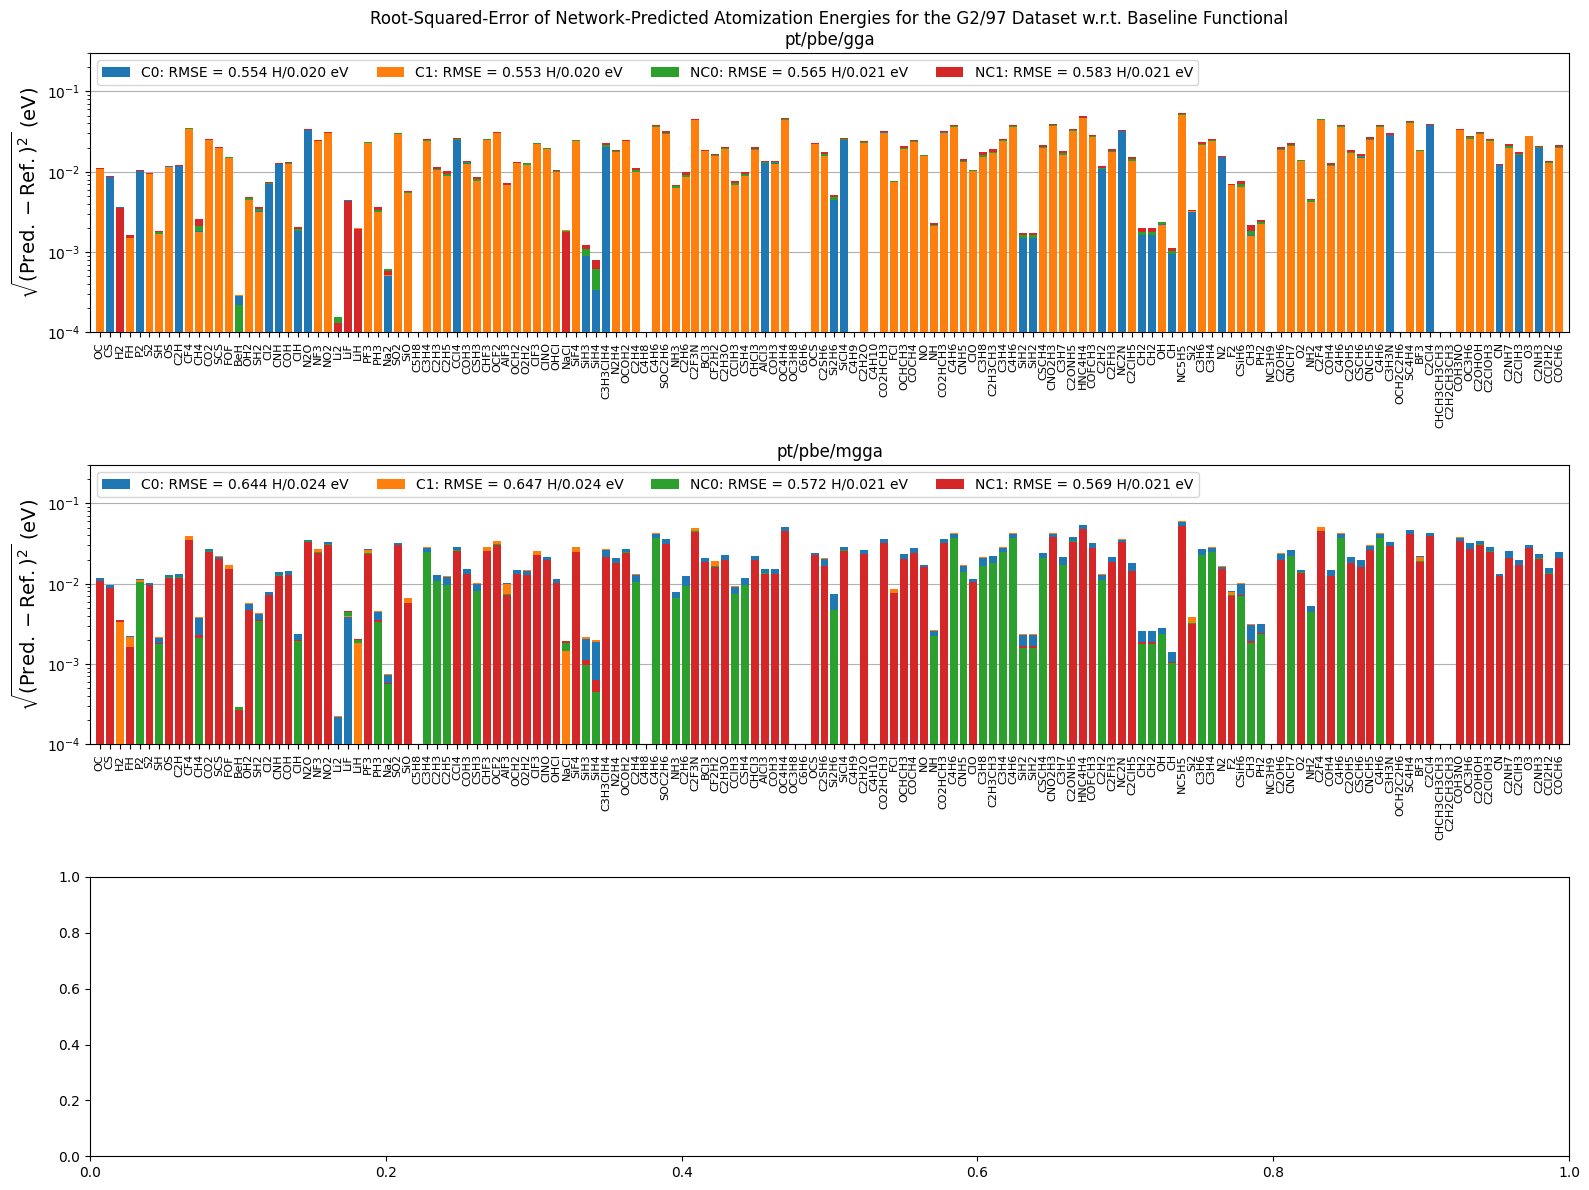

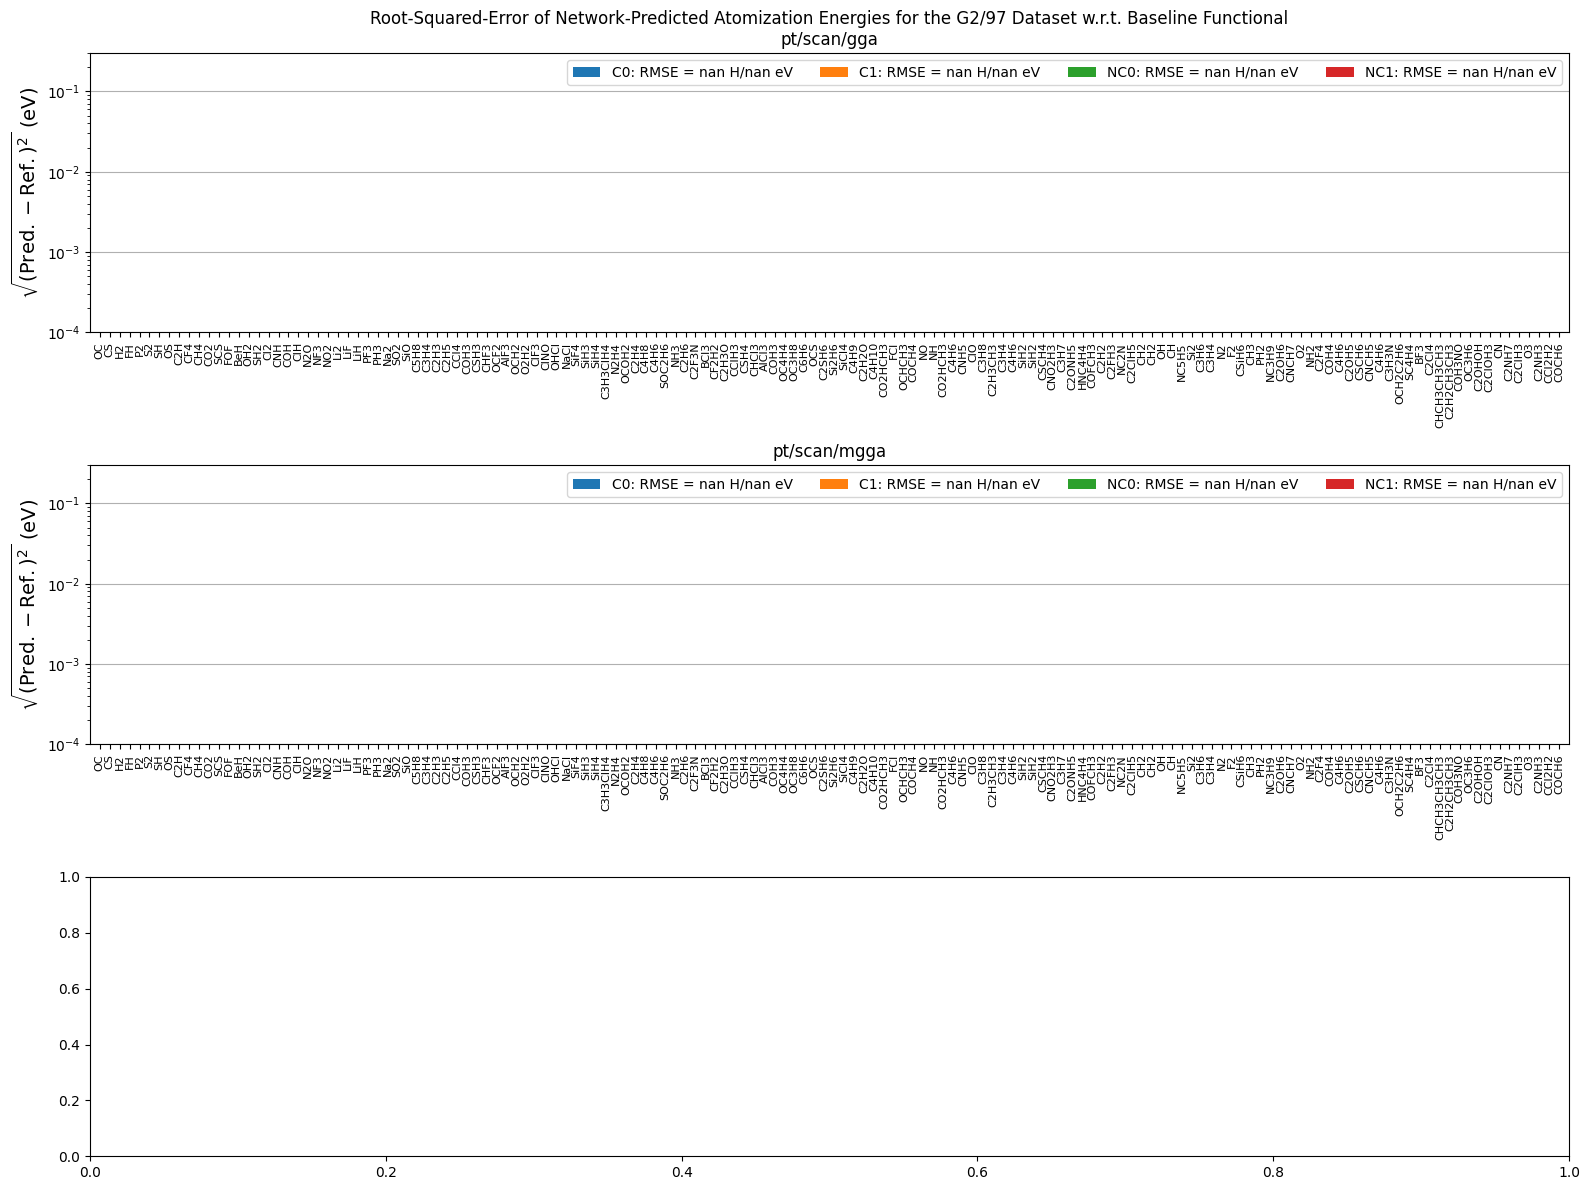

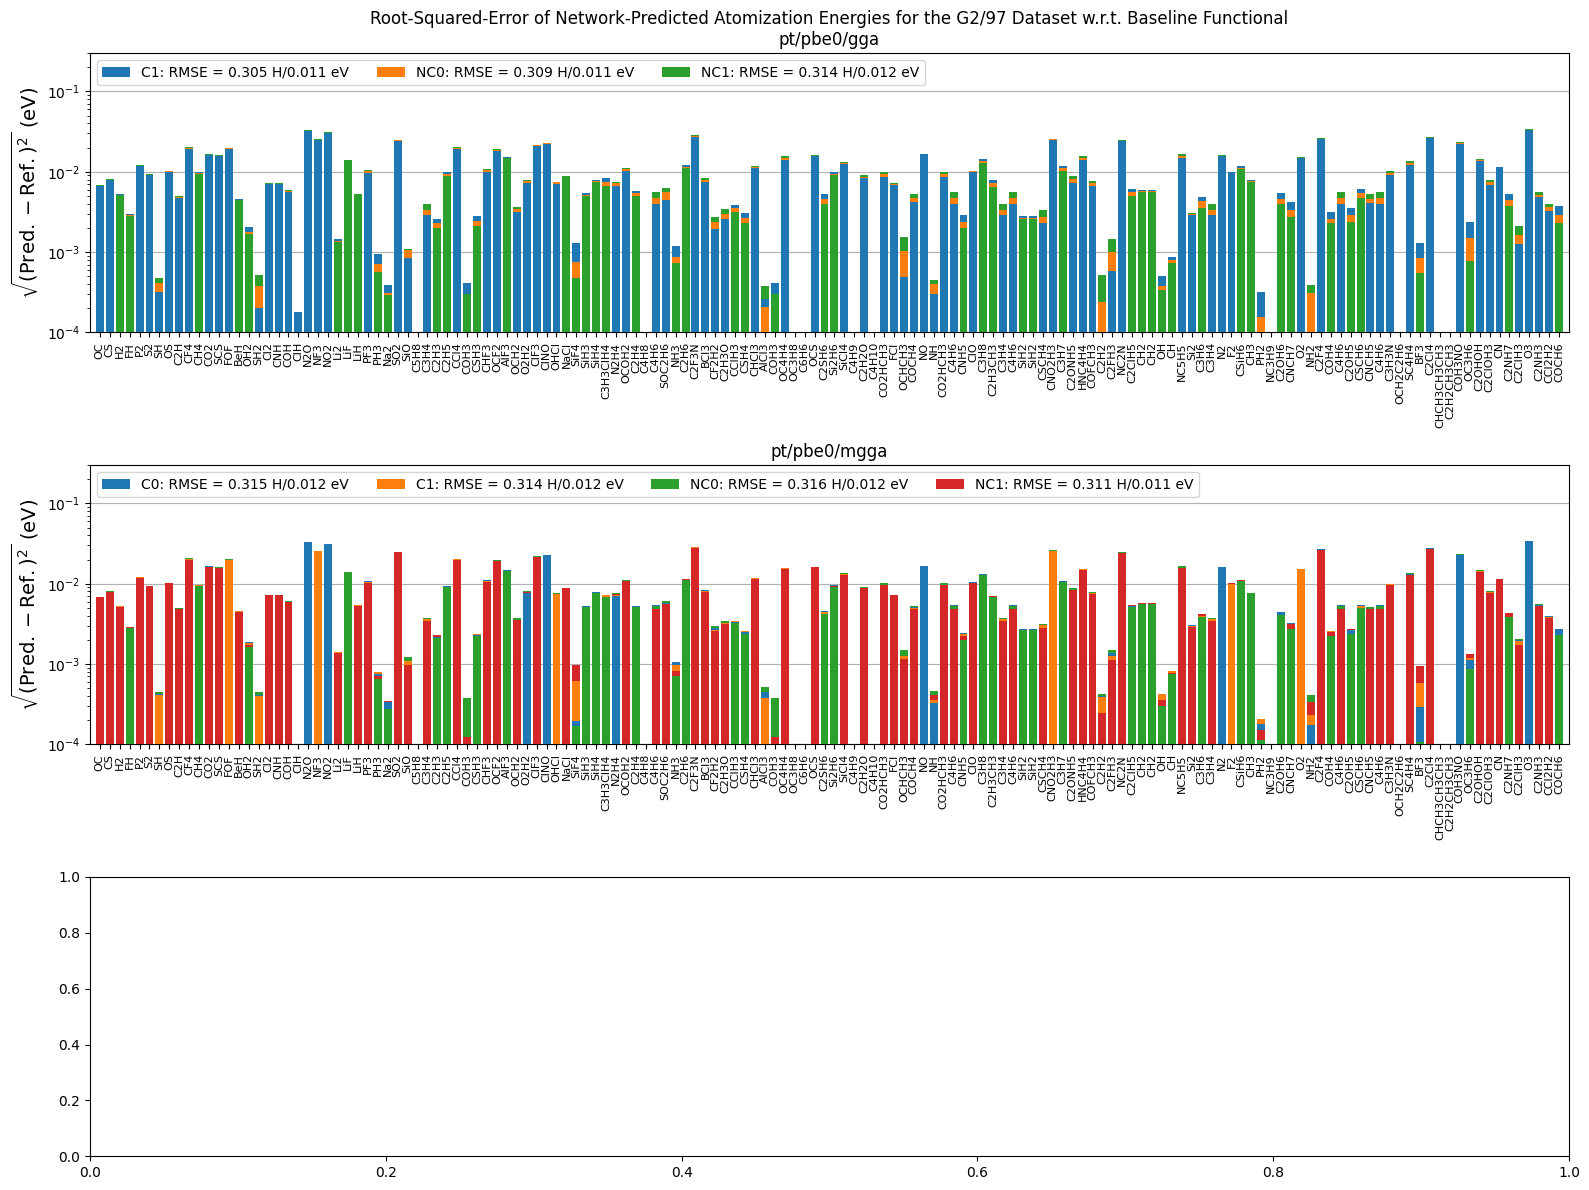

In [95]:
labs = [str(i.symbols) for i in refs]
xs = np.arange(0, len(labs))
CONV = 27.2114
for subd in subds:
    keys = sorted(list(RSE_DCT[subd].keys()))
    lds = [ [i for i in keys if '_gga' in i], [i for i in keys if '_mgga' in i], [i for i in keys if '_nl' in i] ]
    f = plt.figure(figsize=(16,12))
    axg = f.add_subplot(311)
    axm = f.add_subplot(312)
    axn = f.add_subplot(313)
    axd = {'GGA': axg, 'MGGA': axm, 'NL': axn}
    for idx, levelnet in enumerate(lds):
        if not len(levelnet):
            continue
        level = levelnet[0].split('_')[-1].upper()
        ax = axd[level]
        ax.set_xticks(xs)
        ax.yaxis.grid()
        ax.set_yscale('log')
        ax.set_xlim(-1, xs[-1]+1)
        ax.set_ylim(1e-4, 3e-1)
        ax.set_ylabel('$\sqrt{(\mathrm{Pred.}-\mathrm{Ref.})^2}$ (eV)', fontsize=14)
        ax.set_xticklabels(labs, rotation=90, fontsize=8)
        if level == 'GGA':
            ax.set_title('Root-Squared-Error of Network-Predicted Atomization Energies for the G2/97 Dataset w.r.t. Baseline Functional\n{}/{}'.format(subd, levelnet[0].split('_')[-1]))
        else:
            ax.set_title('{}/{}'.format(subd, levelnet[0].split('_')[-1]))
        for net in levelnet:
            dct = RSE_DCT[subd][net]
            vals = []
            for lab in labs:
                try:
                    vals.append(dct[lab]/CONV)
                except Exception as e:
                    # print(e)
                    vals.append(np.nan)
            try:
                thislab = '{}: RMSE = {:3.3f} H/{:3.3f} eV'.format(net.split('_')[-2].upper(),
                                                         RMSE_DCT[subd][net],
                                                         RMSE_DCT[subd][net]/CONV)
                ax.bar(xs, vals, label=thislab)
            except:
                continue
        #make higher errors further back
        for bars in zip(*ax.containers):
            order = np.argsort(np.argsort([b.get_height() for b in bars]))
            for bar, bar_order in zip(bars, order):
                bar.set_zorder(2 + len(ax.containers) - bar_order)
        ax.legend(ncol=4)
        plt.tight_layout()